# Visible Watermark Information Classification Dataset

## Faster R-CNN w/ Keras CV

This notebook shows my attempt to use the Faster R-CNN Object detection model in the Keras CV library.

In [7]:
import os
import math

import keras
import keras_cv
import tensorflow as tf
import keras_tuner as kt

# project utils
from lib.roboflow_yolov8_loader import RoboflowYOLOv8Loader
from lib.utils import visualize_dataset, view_splits

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# attempt to limit memory consumption on the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-detection-VOC2007.v4i.yolov8"

BOUNDING_BOX_FORMAT = "xyxy"
BATCH_SIZE = 8

VALUE_RANGE = (0, 1)

## Load the visual watermark detection data

The splits below show roughly 85/15, but this is because I have also applied augmentations in Roboflow before exporting, increasing the size of the Training split.
The splits in the base dataset before augmentations still remains 70/20/10 (train/validation/10) before augmentation.

In [8]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR, batch_size=BATCH_SIZE)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

# verify split percentage from Roboflow
view_splits(train, val, test)

  0%|          | 0/690 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 16172.76it/s]


         Dataset Splits          
   Split  Percentage
0  train       87.56
1    val        8.38
2   test        4.06


## Data Pre-Processing and Augmentation

Below is the same example of using augmentation for the dataset, shuffling and batching before fine tuning the model.

Augmentation is known to improve accuracy by increasing the size of the dataset dynamically by altering images from the
existing dataset.

In [9]:
augmenters = [
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomContrast(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomHue(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640),
        scale_factor=(0.9, 1.1),
        bounding_box_format=BOUNDING_BOX_FORMAT
    )
]   

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)


resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BOUNDING_BOX_FORMAT, pad_to_aspect_ratio=True
)

def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )

TRAINING_SET_SIZE = len(train) # get total value before augmentation and batching
STEPS_PER_EPOCH = math.floor(TRAINING_SET_SIZE / BATCH_SIZE)
NUM_EPOCHS = 150

# load into correct format for the model
train_ds = ( train
                .shuffle(BATCH_SIZE * len(CLASS_IDS))
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

val_ds =   ( val
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

test_ds =  ( test
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

TRAINING DATA


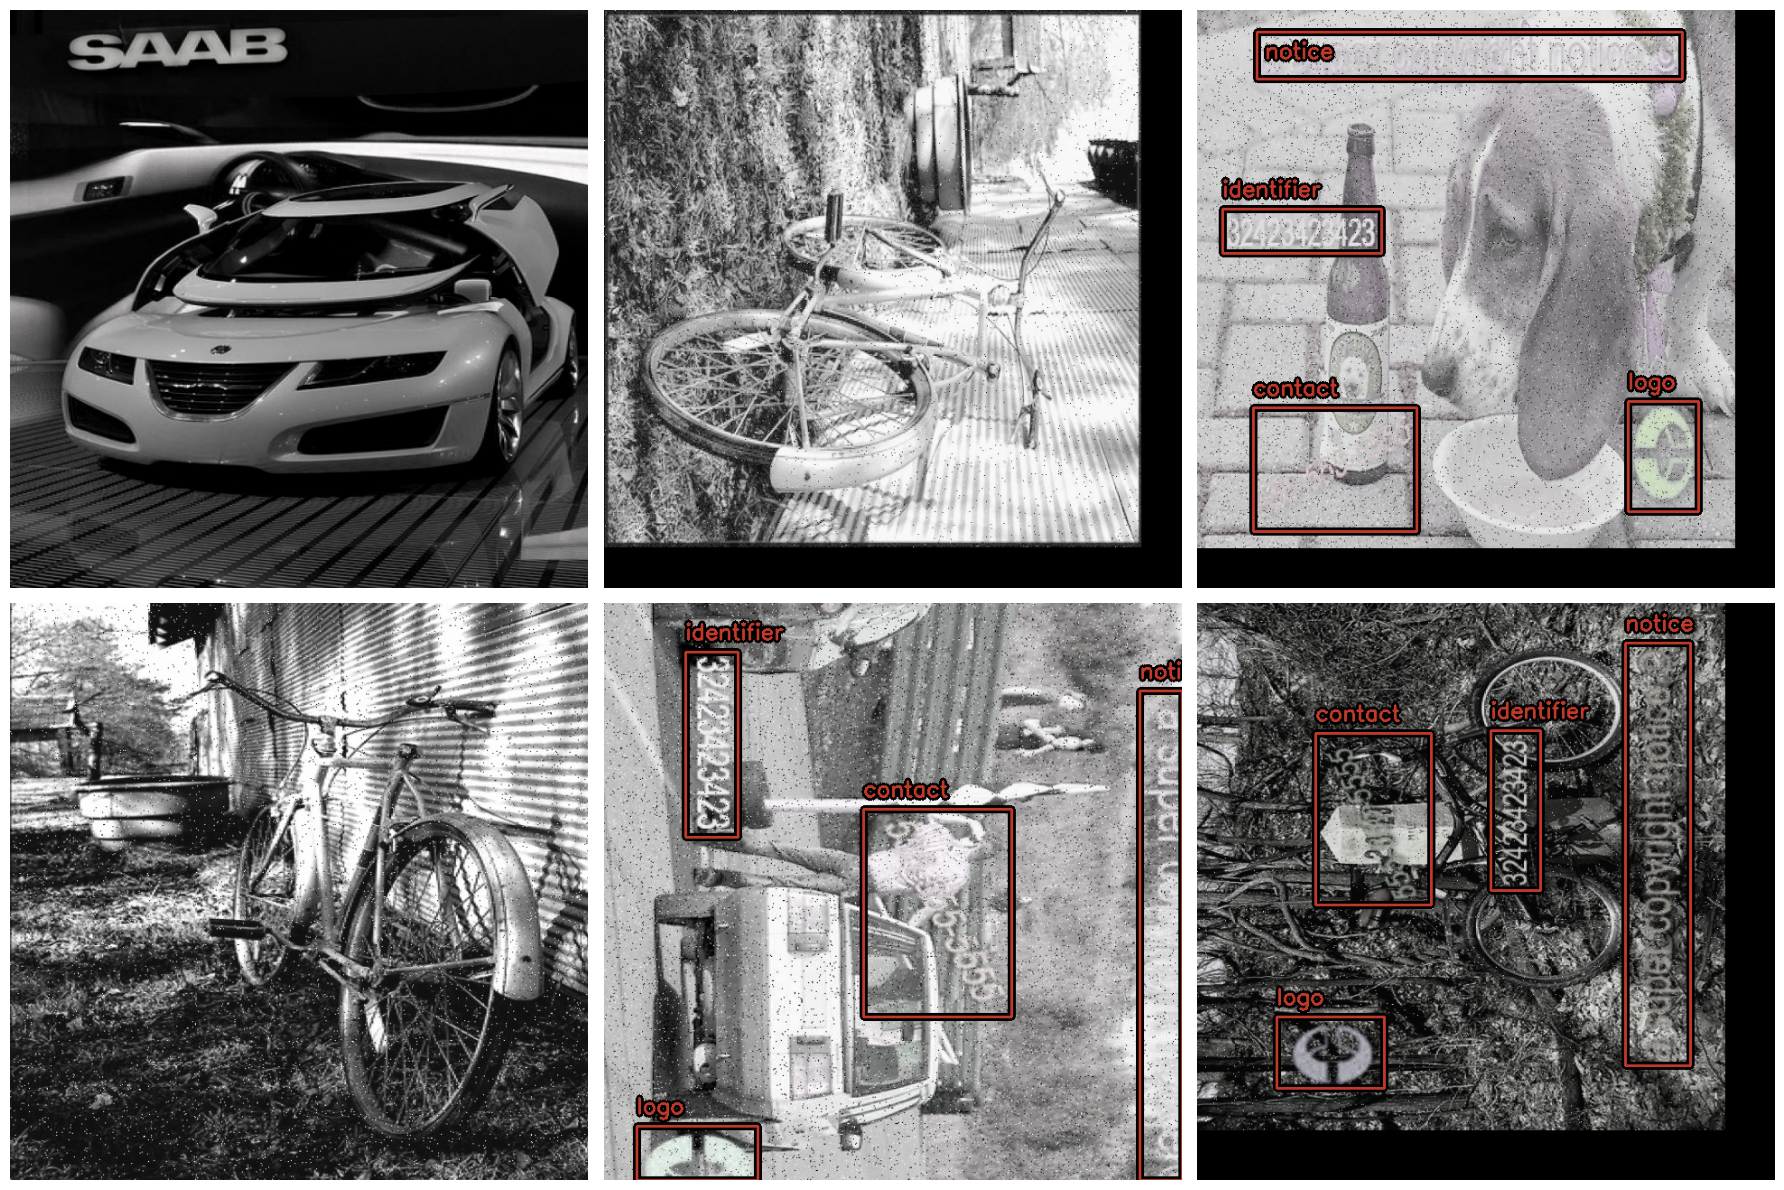

In [10]:
# visualize the training split.
print("TRAINING DATA")
visualize_dataset(
    train_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    rows=2, cols=3, 
)

VALIDATION DATA


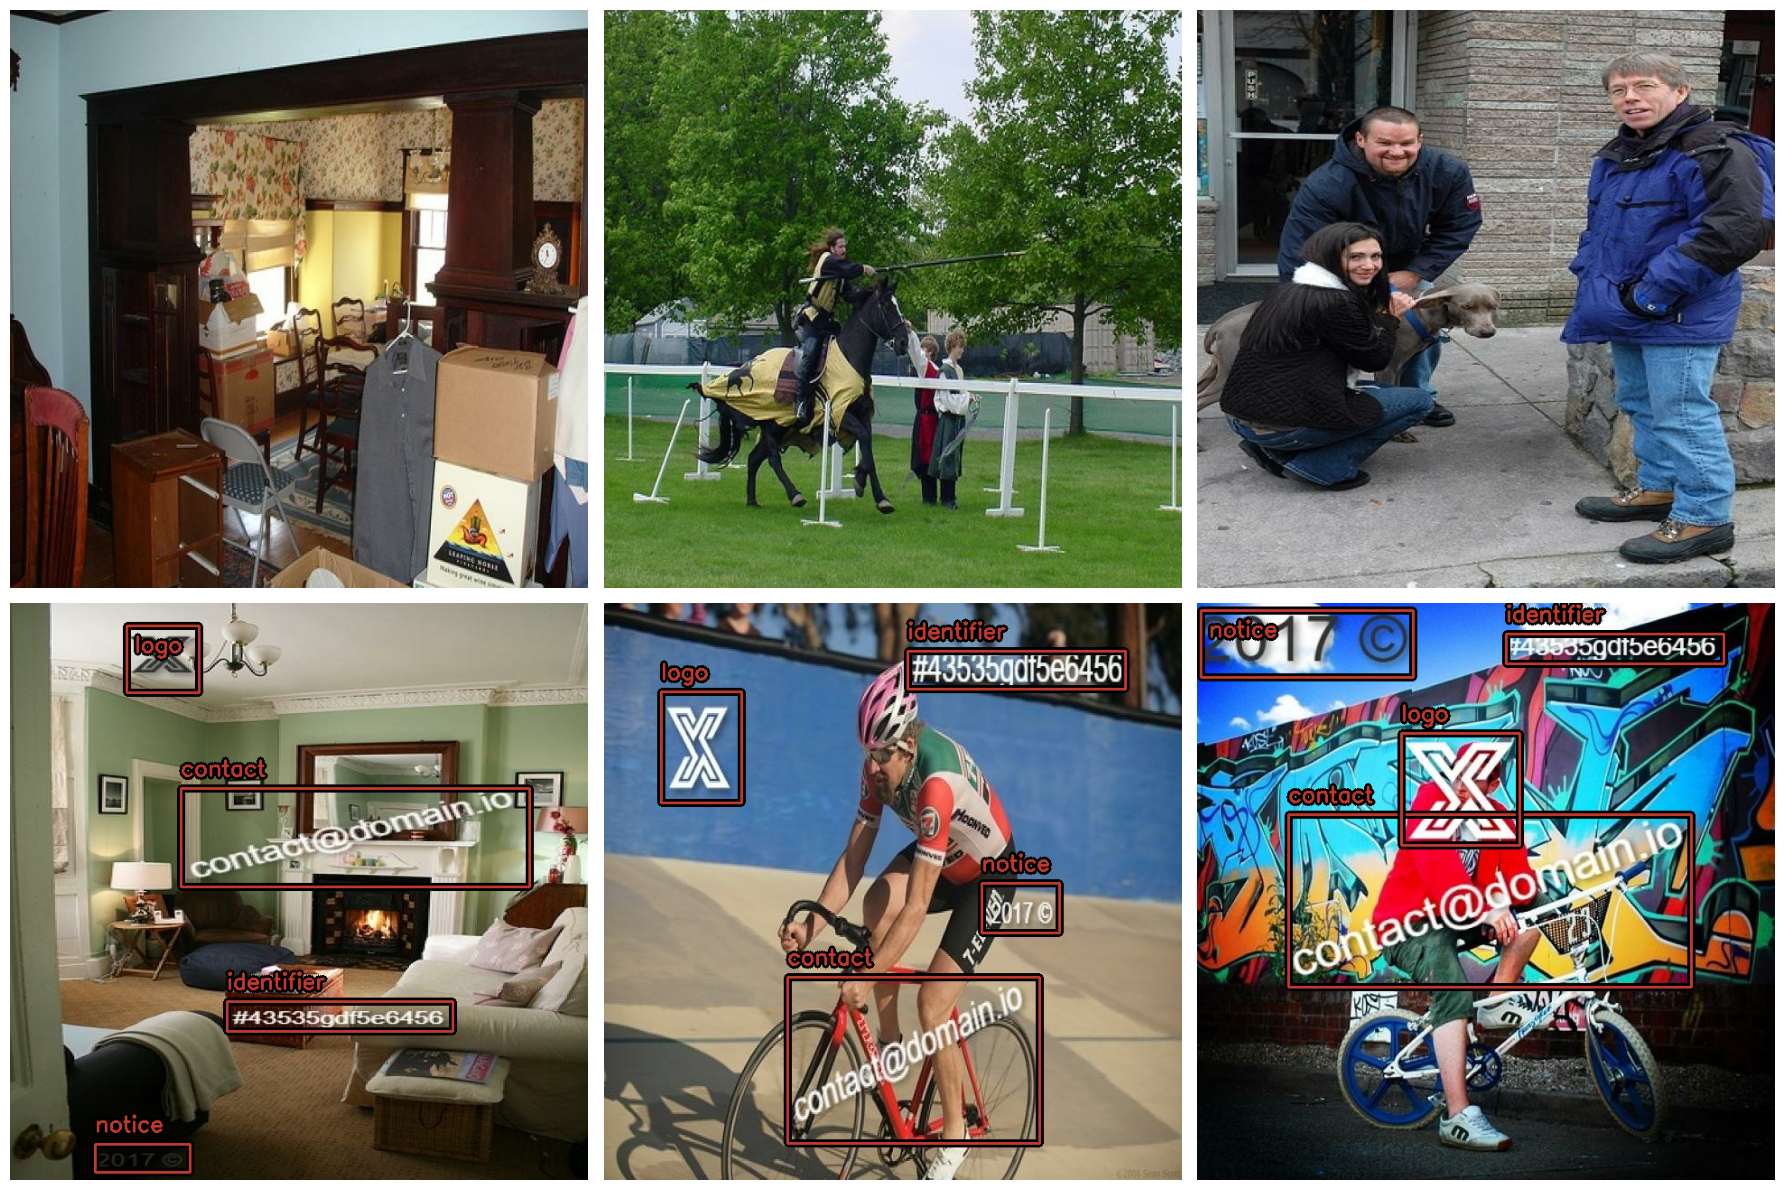

In [11]:
print("VALIDATION DATA")
visualize_dataset(
    val_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    rows=2,
    cols=3,
)

## Train the Faster R-CNN model using custom watermark dataset



In [12]:
import keras_cv.src.models.legacy as legacy

backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")

model = legacy.FasterRCNN(
    num_classes=len(CLASS_IDS),
    bounding_box_format=BOUNDING_BOX_FORMAT,
    backbone=backbone,
)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=math.floor(STEPS_PER_EPOCH * NUM_EPOCHS),
    alpha=0.0,
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, global_clipnorm = 10.0)

model.compile(
    optimizer=optimizer,
    classification_loss=keras_cv.losses.FocalLoss(),
    box_loss=keras_cv.losses.CIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
    rpn_box_loss=keras_cv.losses.CIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
    rpn_classification_loss=keras_cv.losses.FocalLoss(from_logits=True),
)

In [13]:
def visualize_detections(model, dataset, bounding_box_format, class_mapping):
    """Used to plot detections from the YOLOv8 model."""
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)

    # Denormalize images to 0-255 since value_range parameter doesn't seem to work
    images_denormalized = tf.cast(images * 255.0, dtype=tf.uint8)

    keras_cv.visualization.plot_bounding_box_gallery(
        images_denormalized,  # Use denormalized images
        value_range=(0, 255),  # Set value_range to [0, 255]
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


class VisualizeDetections(keras.callbacks.Callback):
    """Used to visualize detection progress after each epoch.
    Reference: https://keras.io/examples/vision/yolov8/
    """
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model,
            bounding_box_format=BOUNDING_BOX_FORMAT,
            dataset=val_ds,
            class_mapping=data_loader.class_mapping,
        )

# Train the YOLOv8 model using custom watermark image dataset.
model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, # matches decay_steps for regularization
    epochs=NUM_EPOCHS,  # early stopping callback may mean this is never reached.
    callbacks=[
        # Tuning the model based on metrics from this callback has been very inconsistent. 
        # This is left here for demonstration purposes, but should be replaced.
        # Github issues:
        #   - https://github.com/keras-team/keras-cv/issues/2402
        #   - https://github.com/keras-team/keras-cv/issues/2442
        keras_cv.callbacks.PyCOCOCallback(  # COCO metrics (AP/AR @ IOU)
            val_ds,
            bounding_box_format=BOUNDING_BOX_FORMAT,
        ),
        keras.callbacks.TensorBoard(  # training progress visualization
            log_dir="training_logs"
        ),
        keras.callbacks.ModelCheckpoint(
            filepath="./model/best_model.keras",
            monitor="val_loss",     # using combination of class/box loss since PyCOCOCallback unreliable.
            save_best_only=True,  # Only keep the best model
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            patience=5,
            monitor="val_loss", # using combination of class/box loss since PyCOCOCallback unreliable.
            verbose=1,
            restore_best_weights=True,  # Restore weights of the best epoch
        ),
        # VisualizeDetections(),  # visual validation after each epoch
    ],
    # verbose=0,  # suppress epoch output since monitoring in TensorBoard.
)

Epoch 1/150


ValueError: '__rpn_label_encoder' is not a valid root scope name. A root scope name has to match the following pattern: ^[A-Za-z0-9.][A-Za-z0-9_.\\/>-]*$